In [1]:
%matplotlib notebook

In [27]:
import numpy as np
from matplotlib import pyplot
import astropy.constants
import scipy.integrate as integrate

In [134]:
def magnitude(vector):
    return np.sqrt(vector[0] ** 2.0 + vector[1] ** 2.0 + vector[2] ** 2.0)

def distance(func):
    return np.trapz(func, dx=1, axis=0)

In [157]:
class Particle(object):
    def __init__(self, initial_position, initial_velocity, mass, number_time_steps):
        self.position = np.zeros((number_time_steps, 3))
        self.position[0] = initial_position
        self.velocity =  np.zeros((number_time_steps, 3))
        self.velocity[0] = initial_velocity
        self.acceleration = np.zeros((number_time_steps, 3))
        self.mass = mass
        self.pvec = np.zeros((number_time_steps, 3))
        self.pvec[0] = mass * np.cross(initial_position, initial_velocity)
        self.pmag = np.zeros((number_time_steps, 1))
        self.pmag[0] = magnitude(mass * np.cross(initial_position, initial_velocity))
        self.emag = np.zeros((number_time_steps, 1))
        self.speed = np.zeros((number_time_steps, 1))
        self.speed[0] = magnitude(initial_velocity)
        self.distance = np.zeros((number_time_steps, 1))
        self.distance[0] = 0
        
    def update_position(self, t):
        self.position[t] = self.position[t - 1]
        self.position[t] += self.velocity[t - 1] * delta_t
        self.position[t] += 0.5 * self.acceleration[t - 1] * delta_t * delta_t
    
    def update_velocity(self, t):
        self.velocity[t] = self.velocity[t - 1]
        self.velocity[t] += 0.5 * delta_t * (self.acceleration[t] + self.acceleration[t - 1])
    
    def update_acceleration(self, t, particles):
        for particle in particles:
            if particle != self:
                r12 = particle.vector_to(self.position, t)
                self.acceleration[t] += G * np.asarray(particle.mass) * r12 / magnitude(r12) ** 3.0
        
    def vector_to(self, position1, t):
        return self.position[t] - position1[t]
    
    def p_vector(self, t):
        self.pvec[t] = self.mass * np.cross(self.position[t], self.velocity[t])
        
    def p_magnitude(self, t):
        self.pmag[t] = magnitude(self.pvec[t])
        
    def e_magnitude(self, t, particles):
        for particle in particles:
            if particle != self:
                r12 = particle.vector_to(self.position, t)
                self.emag[t] = 0.5 * self.mass * np.dot(self.velocity[t], self.velocity[t]) -G * self.mass * np.asarray(particle.mass) / magnitude(r12)
                
    def update_speed(self, t):
        self.speed[t] = magnitude(self.velocity[t])

Distances in Au, Speeds in Au/day, Times in days

In [283]:
number_of_time_steps =100000
delta_t = 1.0
G = astropy.constants.G.to('AU**3 / (day**2 * earthMass)').value

In [284]:
sun = Particle([0.0, 0.0, 0.0], [0.0, 0.0, 0.0], 333000, number_of_time_steps)

In [285]:
pl1 = Particle([0.0, 0.6, 0.0], [-2 * np.pi / np.sqrt(0.6) / 365.25, 0.0, 0.0], 0.5, number_of_time_steps)

In [286]:
pl2 = Particle([1.5, 0.0, 0.0], [0.0, 2 * np.pi / np.sqrt(1.5) / 365.25, 0.0], 1.0, number_of_time_steps)

In [287]:
pl3 = Particle([-6.5, 0.0, 0.0], [0.0, -2 * np.pi / np.sqrt(6.5) / 365.25, 0.0], 30.0, number_of_time_steps)

In [288]:
pl4 = Particle([10.0, 0.0, 0.0], [0.0, 2 * np.pi / np.sqrt(10.0) / 365.25, 0.0], 300.0, number_of_time_steps)

In [289]:
particles = [sun, pl1, pl2, pl3, pl4]

In [290]:
for particle in particles:
    particle.update_acceleration(0, particles)
    particle.e_magnitude(0, particles)

In [291]:
for t in np.arange(1, number_of_time_steps):
    for particle in particles:
        particle.update_position(t)
    for particle in particles:
        particle.update_acceleration(t, particles)
    for particle in particles:
        particle.update_velocity(t)
    for particle in particles:
        particle.p_vector(t)
    for particle in particles:
        particle.p_magnitude(t)
    for particle in particles:
        particle.e_magnitude(t, particles)
    for particle in particles:
        particle.update_speed(t)

<IPython.core.display.Javascript object>


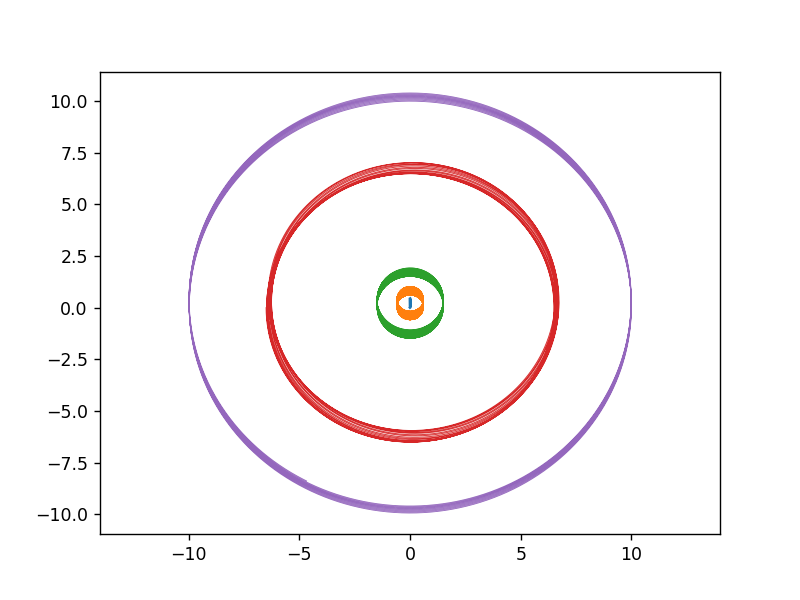

(-14, 14)

In [294]:
pyplot.plot(sun.position[:, 0], sun.position[:, 1])
pyplot.plot(pl1.position[:, 0], pl1.position[:, 1], linewidth=0.1)
pyplot.plot(pl2.position[:, 0], pl2.position[:, 1], linewidth=0.1)
pyplot.plot(pl3.position[:, 0], pl3.position[:, 1], linewidth=0.5)
pyplot.plot(pl4.position[:, 0], pl4.position[:, 1], linewidth=0.5)
pyplot.xlim(-14, 14)
#pyplot.ylim(-5.5, 5.5)

In [295]:
pl1_d = distance(pl1.speed)
pl2_d = distance(pl2.speed)
pl3_d = distance(pl3.speed)
pl4_d = distance(pl4.speed)

In [296]:
pl11_ratio = pl1_d / pl1_d
pl12_ratio = pl1_d / pl2_d
pl13_ratio = pl1_d / pl3_d
pl14_ratio = pl1_d / pl4_d

In [297]:
np.array([pl11_ratio, pl12_ratio, pl13_ratio, pl14_ratio])

array([[1.        ],
       [1.58062636],
       [3.28974987],
       [4.0813837 ]])

These values are the ratios of the orbital periods (and also the orbital distances) of each planet, from pl1 to pl4.

<IPython.core.display.Javascript object>


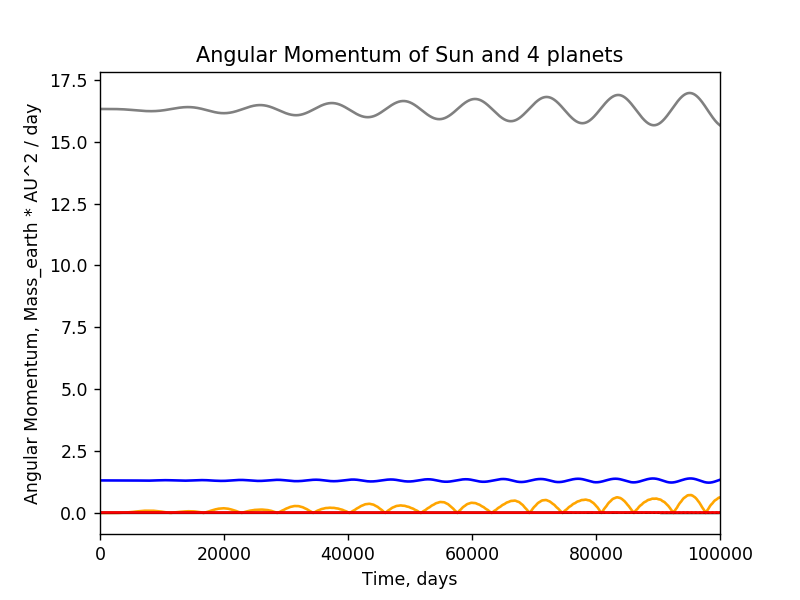

Text(0.5,0,'Time, days')

In [320]:
time = np.arange(0, number_of_time_steps, 1)
pyplot.plot(time, sun.pmag, color="orange")
pyplot.plot(time, pl1.pmag, color="black")
pyplot.plot(time, pl2.pmag, color="red")
pyplot.plot(time, pl3.pmag, color="blue")
pyplot.plot(time, pl4.pmag, color="gray")
pyplot.xlim(0, number_of_time_steps)
pyplot.title("Angular Momentum of Sun and 4 planets")
pyplot.ylabel("Angular Momentum, Mass_earth * AU^2 / day")
pyplot.xlabel("Time, days")

<IPython.core.display.Javascript object>


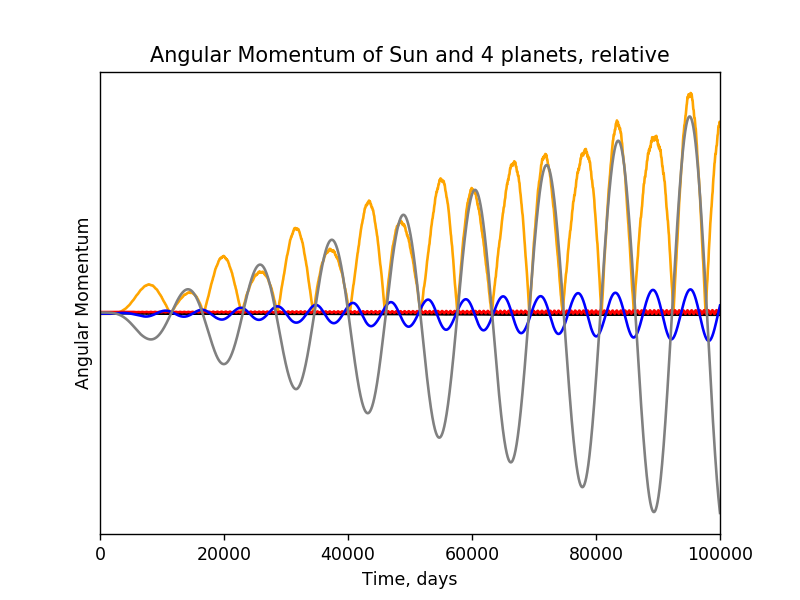

Text(0,0.5,'Angular Momentum')

In [321]:
time = np.arange(0, number_of_time_steps, 1)
pyplot.plot(time, sun.pmag + 1.305, color="orange")
pyplot.plot(time, pl1.pmag + 1.3, color="black")
pyplot.plot(time, pl2.pmag + 1.29, color="red")
pyplot.plot(time, pl3.pmag - 0.01, color="blue")
pyplot.plot(time, pl4.pmag - 15.01, color="gray")
pyplot.xlim(0, number_of_time_steps)
pyplot.title("Angular Momentum of Sun and 4 planets, relative")
pyplot.yticks([])
pyplot.xlabel("Time, days")
pyplot.ylabel("Angular Momentum")

Due to the calculation, the Sun's momentum is shown as the absolute value of the momentum. However, in adjusting our perspective we can see that conservation of angular momentum is true in this system.

<IPython.core.display.Javascript object>


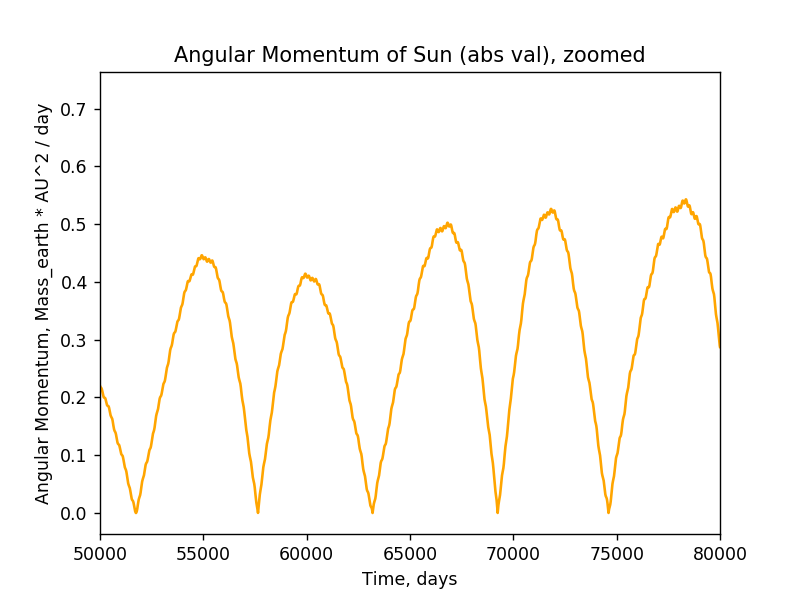

Text(0,0.5,'Angular Momentum, Mass_earth * AU^2 / day')

In [322]:
pyplot.plot(time, sun.pmag, color="orange")
pyplot.xlim(50000, 80000)
pyplot.title("Angular Momentum of Sun (abs val), zoomed")
pyplot.xlabel("Time, days")
pyplot.ylabel("Angular Momentum, Mass_earth * AU^2 / day")

The modulation in the oscillation of the Sun's angular momentum is caused by the positions of the planets as they orbit the Sun, and as the angular momentum of the Sun decreases, the momentum of the planet(s) increases. The small modulations indicate that there are bodies orbitting the Sun that are slightly affecting its motion.